# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
        
from abc import ABC, abstractmethod


## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        pass
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        pass

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert isinstance(narms,int),"'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."
        assert isinstance(epsilon, float),"'epsilon should be a float.'"
        assert epsilon >= 0 and epsilon <=1,"the value of 'epsilon' should between 0 and 1. "
        assert isinstance(Q0,float),"'Q0' should be a real-value"
        
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        # state to store average rewards for each arm 
        self.avg_rewards = np.zeros(narms,dtype=float)
        # state to store total rewards observed for each arm
        self.total_rewards = np.zeros(narms,dtype=float)
        # state to store total counts for which each arm has been played       
        self.counts = np.zeros(narms,dtype=int)
        
    def play(self, tround, context=None):
        # Binamial random number generator with probabilty of success defined
        # by epsilon
        if np.random.binomial(n=1, p=self.epsilon) == 0:
            # Exploit by playing the arm which has the highest average rewards  
            # so far with random tie-breaking 
            max_value = max(self.avg_rewards)
            candidate_arm = []
            for i in range(len(self.avg_rewards)):
                if self.avg_rewards[i] == max_value:
                    candidate_arm.append(i)
                   
            candidate = np.random.choice(candidate_arm)
        else:
        # Explore by randomly picking up an arm with equal probability                                                          
            candidate = np.random.randint(low=0, high=self.narms) 
        
        return(candidate+1)
    
    def update(self, arm, reward, context=None):
        assert arm <= self.narms,"the value of 'arm' should no larger than 'narms' "
        self.counts[arm]+=1
        self.total_rewards[arm]+=1
        self.avg_rewards[arm]=self.total_rewards[arm]/self.counts[arm]
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert isinstance(narms,int),"'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."
        assert isinstance(rho, float),"'epsilon should be a float.'"
        assert rho > 0,"'rho' should be a positive real-value. "
        assert isinstance(Q0,float),"'Q0' should be a real-value."
    
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
         # state to store average rewards for each arm 
        self.avg_rewards = np.zeros(narms,dtype=float)
        # state to store total rewards observed for each arm
        self.total_rewards = np.zeros(narms,dtype=float)
        # state to store total counts for which each arm has been played       
        self.counts = np.zeros(narms,dtype=int)
    
    def play(self, tround, context=None):
        # Store UCB values for each arm
        upper_bound_probs = np.full(self.narms, self.Q0)
        # Update UCB values for each arm
        for i in range(len(upper_bound_probs)):
        # Only update the initialized UCB values for arms those has been played at least once 
            if self.counts[i]>0:
                upper_bound_probs[i]=(self.avg_rewards[i]+np.sqrt((self.rho*np.log(tround))/self.counts[i]))
        # Select arm which has the highest UCB values so far with random tie-breaking                  
        max_value = max(upper_bound_probs)    
        candidate_arm=[]
        for i in range (self.narms):
            if upper_bound_probs[i] == max_value:
                candidate_arm.append(i)
        candidate = np.random.choice(candidate_arm)
        return(candidate+1)
        
    def update(self, arm, reward, context=None):
        assert arm <= self.narms,"the value of 'arm' should no larger than 'narms' "
        self.counts[arm]+=1
        self.total_rewards[arm]+= reward
        self.avg_rewards[arm]=self.total_rewards[arm]/self.counts[arm]
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        assert isinstance(narms,int),"'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."
        assert isinstance(alpha0, float),"'epsilon should be a real-value.'"
        assert alpha0 > 0,"'alpha0' should be a positive real-value. "
        assert isinstance(beta0, float),"'epsilon should be a real-value.'"
        assert beta0 > 0,"'beta0' should be a positive real-value. "
    
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        # state to store total rewards(numbers of wins) observed for each arm
        self.total_rewards = np.zeros(narms,dtype=float)
        # state to store total counts for which each arm has been played       
        self.counts = np.zeros(narms,dtype=int) 
    
    def play(self, tround, context=None):
         # Store basic Thompson values for each arm
        Thompson_sample_value = np.zeros(self.narms)
        # Update Thompson sample values (beta distribution) for each arm
        for i in range(len(Thompson_sample_value)): 
            Thompson_sample_value[i] = np.random.beta(self.total_rewards[i]+self.alpha0,self.counts[i]-self.total_rewards[i]+self.beta0)
            
        # Select arm which has the highest Thompson values so far with random tie-breaking         
        max_value = max(Thompson_sample_value)    
        candidate_arm=[]
        for i in range (self.narms):
            if Thompson_sample_value[i] == max_value:
                candidate_arm.append(i)
        candidate = np.random.choice(candidate_arm)
        
        return(candidate+1)
        
    def update(self, arm, reward, context=None):
        assert arm <= self.narms,"the value of 'arm' should no larger than 'narms' "
        self.counts[arm]+=1
        self.total_rewards[arm]+= reward

## 3. Off-Policy Evaluation

In [6]:
#Read data, ensure the dataset.txt is located in the same directory as this notebook
dataset = np.loadtxt('dataset.txt')
arms = dataset[:,0].astype(int)
rewards = dataset[:,1]
contexts = dataset[:,2:102]

In [7]:
print(arms)
print(rewards)
print(contexts)

[2 8 5 ... 9 4 4]
[0. 0. 0. ... 1. 0. 0.]
[[ 5.  0.  0. ... 30.  4.  0.]
 [ 1.  3. 36. ...  0.  0. 10.]
 [ 3.  0.  0. ...  3.  0.  0.]
 ...
 [79.  0.  0. ...  0.  0.  0.]
 [29.  0.  2. ... 17.  0.  0.]
 [ 0.  2. 35. ...  0.  0. 12.]]


In [25]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    tround = 1
    arm_selected = []
    per_round_rewards = []
    # If nrounds is None, play until stream_iterator is done
    if nrounds == None:
        nrounds = len(arms)
    
    for i in range(len(arms)):
        played_arm = mab.play(tround,contexts[i])
        if played_arm == arms[i]:
            reward = rewards[i]
            mab.update(played_arm-1,reward,contexts[i])
            arm_selected.append([played_arm,reward])
            per_round_rewards.append(reward)
            if tround == nrounds:
                return(per_round_rewards)
            tround+=1
    
    
    return(per_round_rewards)
    

In [26]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.12625


In [27]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.165


In [11]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2275


## 4. Contextual Bandits - LinUCB

In [12]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert isinstance(narms, int), "'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."
        assert isinstance(ndims, int), "'ndims' should be an integer."
        assert ndims > 0, "'ndims' should be a positive integer."
        assert isinstance(alpha, float),"'alpha' shoulde be a real-value number"
        
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        #Initialize ndims dimensional identity matrix for each arm
        self.A = [np.identity(self.ndims)]*self.narms
        #Initialize dimes dimensional zero vector for each arm
        self.b = [np.zeros(self.ndims)]*self.narms
        
    def play(self, tround, context):
        #Initialize null coefficient vector for each arm
        theta_hat = [np.zeros(self.ndims)]*self.narms
        #Initialzie expected pay off for each arm
        p_t_a = np.zeros(self.narms)
        #Updaate expected pay-off for each arm
        for i in range(self.narms):
            context_arm = context[i * self.narms:(i+1) * self.narms]
            theta_hat[i] = np.linalg.inv(self.A[i]) @ self.b[i]
            p_t_a[i] = (theta_hat[i].T @ context_arm) + self.alpha*np.sqrt(context_arm @ np.linalg.inv(self.A[i]) @ context_arm.T)
        
        # Select arm which has the highest linUCB values so far with random tie-breaking         
        max_value = max(p_t_a)    
        candidate_arm =[]
        for i in range (self.narms):
            if p_t_a[i] == max_value:
                candidate_arm.append(i)
        candidate = np.random.choice(candidate_arm)
        
        return(candidate+1)
    
    def update(self, arm, reward, context):
        assert arm <= self.narms, "'arm' should no larger than property 'self.narms'"
        context_arm = context[(arm*self.narms):(arm+1)*self.narms]
        self.A[arm] = self.A[arm] + context_arm @ context_arm.T
        self.b[arm] = self.b[arm] + reward*context_arm
        

In [13]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2675


## 5. Contextual Bandits - LinThompson

In [14]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        assert isinstance(narms, int), "'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."
        assert isinstance(ndims, int), "'ndims' should be an integer."
        assert ndims > 0, "'ndims' should be a positive integer."
        assert isinstance(v, float),"'v' shoulde be a real-value number"
        
        self.narms = narms
        self.ndims = ndims
        self.v = v
        #Initialize ndims dimensional identity matrix for each arm
        self.B = [np.identity(self.ndims)]*self.narms
        #Initialize dimes dimensional zero vector for each arm
        self.mu_hat = [np.zeros(self.ndims)]*self.narms
        self.f = [np.zeros(self.ndims)]*self.narms
        
    def play(self, tround, context):
        p_t_arm = np.zeros(self.narms)
        sample_mu = [np.zeros(self.ndims)]*self.narms 
        for i in range(self.narms):
            sample_mu[i] = np.random.multivariate_normal(self.mu_hat[i],self.v**2*np.linalg.inv(self.B[i]))
            p_t_arm[i] = context[i * self.narms:(i+1) * self.narms].T @ sample_mu[i]
        
          # Select arm which has the highest linUCB values so far with random tie-breaking         
        max_value = max(p_t_arm)    
        candidate_arm =[]
        for i in range (self.narms):
            if p_t_arm[i] == max_value:
                candidate_arm.append(i)
        candidate = np.random.choice(candidate_arm)
        
        return(candidate+1)
    
    def update(self, arm, reward, context):
        assert arm <= self.narms, "'arm' should no larger than property 'self.narms'"
        context_arm = context[(arm*self.narms):(arm+1)*self.narms]
        self.B[arm] = self.B[arm] + context_arm @ context_arm.T
        self.f[arm] = self.f[arm] + reward*context_arm
        self.mu_hat[arm] = np.linalg.inv(self.B[arm]) @ self.f[arm]

In [15]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.33375


## 6. Evaluation
### 6.A.

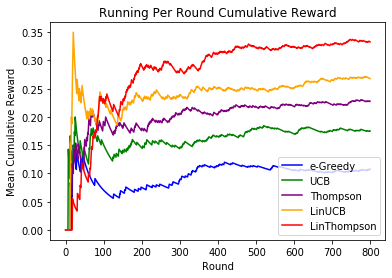

In [18]:
def plot(tround):
  
    assert isinstance(tround, int), "'t' argument should be an integer."
    assert tround > 0, "'t' argument should be a positive integer."   
    # Initialize arrays with zeros to store mean cumulative rewards upto t 
    # rounds for each of the three implemented bandit algorithms
    reward_EpsGreedy = np.zeros(tround)
    reward_Thompson = np.zeros(tround)
    reward_UCB = np.zeros(tround)
    reward_LinUCB = np.zeros(tround)
    reward_LinThompson = np.zeros(tround)
    # For each round, store the mean cumulative rewards upto that round
    for i in range(1,tround):
        reward_EpsGreedy[i] = np.sum(results_EpsGreedy[0:i]) / i
        reward_UCB[i] = np.sum(results_UCB[0:i]) / i
        reward_Thompson[i] = np.sum(results_BetaThompson[0:i])/i
        reward_LinUCB[i] = np.sum(results_LinUCB[0:i]) / i
        reward_LinThompson[i] = np.sum(results_LinThompson[0:i])/i
    # Plot running per round cumulative reward
    plt.plot(range(0,tround), reward_EpsGreedy, color='b', label='e-Greedy')
    plt.plot(range(0,tround), reward_UCB, color='g', label='UCB')
    plt.plot(range(0,tround),reward_Thompson,color='purple',label = 'Thompson')
    plt.plot(range(0,tround), reward_LinUCB, color='orange', label='LinUCB')
    plt.plot(range(0,tround),reward_LinThompson, color='r',label='LinThompson')
    plt.xlabel('Round')
    plt.ylabel('Mean Cumulative Reward')
    plt.title('Running Per Round Cumulative Reward')
    plt.legend()
    plt.show()

# Plot running per round cumulative reward for three implemented 
# multi-armed bandits algorithms for 800 matching events    
plot(800)

### 6.B.

Alpha 	 Mean Rewards for 800 Matching Rounds
-100.0 	 0.34
-10.0 	 0.46875
-1.0 	 0.25875
-0.5 	 0.25
-0.1 	 0.1775
0.0 	 0.5275
0.01 	 0.27
0.02 	 0.27
0.05 	 0.27
0.1 	 0.27
0.2 	 0.27125
0.3 	 0.27125
0.4 	 0.27
0.5 	 0.27125
1.0 	 0.2675
2.0 	 0.26875
5.0 	 0.26875
10.0 	 0.27
100.0 	 0.27125


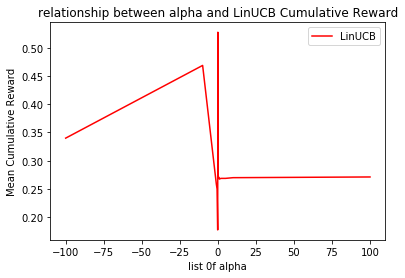


Best Alpha is  0.0  with mean rewards of  0.5275  over 800 matching rounds


In [48]:
def gridSearch(list_of_alpha):

    # Initialize best result to be 0
    best_result = 0.0
    mean_results_LinUCB = np.zeros(len(list_of_alpha))
    # Perform grid search over a list of alpha values
    for j in range(0, len(list_of_alpha)):
        mab = LinUCB(10, 10, list_of_alpha[j])
        mean_results_LinUCB[j] = np.mean(offlineEvaluate(mab, arms, rewards, 
                                                         contexts, 800))  
        if mean_results_LinUCB[j] > best_result:
            best_result = mean_results_LinUCB[j]
            best_alpha = list_of_alpha[j]

    print('Alpha', '\t Mean Rewards for 800 Matching Rounds')  
    for i in range(0, len(list_of_alpha)):
        print(list_of_alpha[i],'\t', mean_results_LinUCB[i])
    
    plt.plot(list_of_alpha, mean_results_LinUCB, color='red', label='LinUCB')
    plt.xlabel('list 0f alpha')
    plt.ylabel('Mean Cumulative Reward')
    plt.title('relationship between alpha and LinUCB Cumulative Reward')
    plt.legend()
    plt.show()
    
    return(best_alpha, best_result)

# Run grid search to find optimal value of hyper-parameter alpha
list_of_alpha = np.array([-100,-10.0,-1.0,-0.5,-0.1,0.0,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,1.0,2.0,5.0,10.0,100])
opt_alpha, opt_result = gridSearch(list_of_alpha)
            
print('\nBest Alpha is ', opt_alpha, ' with mean rewards of ', opt_result,\
      ' over 800 matching rounds')

Nu 	 Mean Rewards for 800 Matching Rounds
-100.0 	 0.255
-10.0 	 0.36125
-1.0 	 0.37875
-0.5 	 0.3925
-0.1 	 0.45
0.0 	 0.4375
0.01 	 0.485
0.02 	 0.335
0.05 	 0.46375
0.1 	 0.44375
0.2 	 0.34625
0.3 	 0.3975
0.4 	 0.405
0.5 	 0.415
1.0 	 0.30625
2.0 	 0.335
5.0 	 0.345
10.0 	 0.33875
100.0 	 0.27


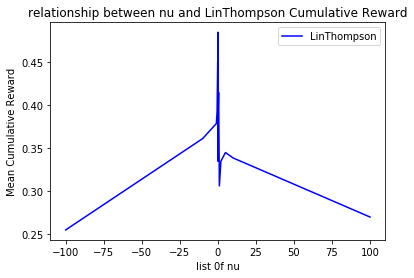


Best nu is  0.01  with mean rewards of  0.485  over 800 matching rounds


In [49]:
def gridSearch(list_of_nu):

    # Initialize best result to be 0
    best_result = 0.0
    mean_results_LinThompson = np.zeros(len(list_of_nu))
    # Perform grid search over a list of alpha values
    for j in range(0, len(list_of_nu)):
        mab = LinThompson(10, 10, list_of_nu[j])
        mean_results_LinThompson[j] = np.mean(offlineEvaluate(mab, arms, rewards, 
                                                         contexts, 800))  
        if mean_results_LinThompson[j] > best_result:
            best_result = mean_results_LinThompson[j]
            best_nu = list_of_nu[j]

    print('Nu', '\t Mean Rewards for 800 Matching Rounds')  
    for i in range(0, len(list_of_nu)):
        print(list_of_nu[i],'\t', mean_results_LinThompson[i])
    
    plt.plot(list_of_nu, mean_results_LinThompson, color='blue', label='LinThompson')
    plt.xlabel('list 0f nu')
    plt.ylabel('Mean Cumulative Reward')
    plt.title('relationship between nu and LinThompson Cumulative Reward')
    plt.legend()
    plt.show()
    
    return(best_nu, best_result)

# Run grid search to find optimal value of hyper-parameter alpha
list_of_nu = np.array([-100,-10.0,-1.0,-0.5,-0.1,0.0,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,1.0,2.0,5.0,10.0,100])
opt_nu, opt_result = gridSearch(list_of_nu)
           
print('\nBest nu is ', opt_nu, ' with mean rewards of ', opt_result,\
      ' over 800 matching rounds')

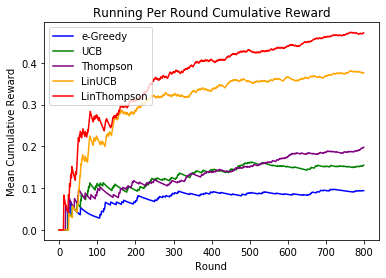

In [51]:
mab = LinUCB(10, 10, 0.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, 
                                                         contexts, 800)
    
mab = LinThompson(10, 10, 0.01)
results_LinThompson = offlineEvaluate(mab, arms, rewards, 
                                                         contexts, 800) 

plot(800)